In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import numpy.random as npr
import random
from scipy.spatial import KDTree
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import sys

sys.setrecursionlimit(10000)

In [2]:
# import housing data (Data taken from person looking to hire someone on Upwork(freelancer website))
# Data must be munged
df = pd.read_csv('data.csv')
df.set_index(['Id'], inplace=True)
print df[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape']].head(10)

    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape
Id                                                                 
1           60       RL         65.0     8450   Pave   NaN      Reg
2           20       RL         80.0     9600   Pave   NaN      Reg
3           60       RL         68.0    11250   Pave   NaN      IR1
4           70       RL         60.0     9550   Pave   NaN      IR1
5           60       RL         84.0    14260   Pave   NaN      IR1
6           50       RL         85.0    14115   Pave   NaN      IR1
7           20       RL         75.0    10084   Pave   NaN      Reg
8           60       RL          NaN    10382   Pave   NaN      IR1
9           50       RM         51.0     6120   Pave   NaN      Reg
10         190       RL         50.0     7420   Pave   NaN      Reg


In [3]:
# Select all columns that are numeric data types and fill NaN values with 0
# The Alley column contains categorical data so the NaN aren't converted at this step
# Compare column LotFrontage row 8 with table below - NaN is converted to Zero
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_columns = df.select_dtypes(include=numerics).columns
df[num_columns] = df[num_columns].apply(lambda x: x.fillna(0))
print df[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape']].head(10)

    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape
Id                                                                 
1           60       RL         65.0     8450   Pave   NaN      Reg
2           20       RL         80.0     9600   Pave   NaN      Reg
3           60       RL         68.0    11250   Pave   NaN      IR1
4           70       RL         60.0     9550   Pave   NaN      IR1
5           60       RL         84.0    14260   Pave   NaN      IR1
6           50       RL         85.0    14115   Pave   NaN      IR1
7           20       RL         75.0    10084   Pave   NaN      Reg
8           60       RL          0.0    10382   Pave   NaN      IR1
9           50       RM         51.0     6120   Pave   NaN      Reg
10         190       RL         50.0     7420   Pave   NaN      Reg


In [12]:
# Select all columns that are objects and convert them to Categorical Data types
obj_columns = df.select_dtypes(['object']).columns
df[obj_columns] = df[obj_columns].apply(lambda x: x.astype('category'))


In [5]:
# Select only category columns and turn category to codes 
# This might be incorrect way to do this because the category aren't value base
# Right way might be to create dummy values
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
print df[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape']].head(10)

    MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape
Id                                                                     
1           60         3         65.0     8450       1     -1         3
2           20         3         80.0     9600       1     -1         3
3           60         3         68.0    11250       1     -1         0
4           70         3         60.0     9550       1     -1         0
5           60         3         84.0    14260       1     -1         0
6           50         3         85.0    14115       1     -1         0
7           20         3         75.0    10084       1     -1         3
8           60         3          0.0    10382       1     -1         0
9           50         4         51.0     6120       1     -1         3
10         190         3         50.0     7420       1     -1         3


In [6]:
# Normalize data
values = df['SalePrice']
houses = df.drop('SalePrice', 1)
houses = (houses - houses.mean()) / (houses.max() - houses.min())

In [7]:
# create KDTree
kdtree = KDTree(houses)

In [8]:
def test_regression(holdout, v, h):
    # Setup training and test data
    test_rows = random.sample(h.index.tolist(),int(round(len(h) * holdout)))
    train_rows = set(range(len(h))) - set(test_rows)
    df_test = h.loc[test_rows]
    df_train = h.drop(test_rows)
    train_values = v.loc[train_rows]
    values_actual = []
    values_regr = []
    for idx, row in df_test.iterrows():
        _, indexes = kdtree.query(row, 5)
        values_regr.append(np.mean(v.iloc[indexes]))
        values_actual.append(v[idx])
    return values_regr, values_actual

In [9]:
def tests(folds, v, h):
    holdout = 1 / float(folds)
    errors = []
    for _ in range(folds):
        values_regress, values_actual = test_regression(holdout, v, h)
        errors.append(mean_absolute_error(values_actual, values_regress))
    return errors

In [10]:
  def plot_error_rates(v, h):
    """
    Plots MAE vs #folds
    """
    folds_range = range(2, 11)
    errors_df = pd.DataFrame({'max': 0, 'min': 0}, index=folds_range)
    for folds in folds_range:
      errors = tests(folds, v, h)
      errors_df['max'][folds] = max(errors)
      errors_df['min'][folds] = min(errors)
    errors_df.plot(title='Mean Absolute Error of KNN over different folds_range')
    plt.xlabel('#folds_range')
    plt.ylabel('MAE')
    plt.show()

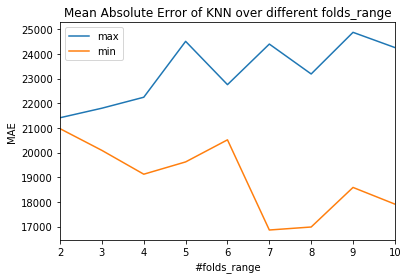

In [11]:
plot_error_rates(values, houses)